In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
base.classes.keys() # This is important in understanding that your tables properly exist in the model

['measurement', 'station']

In [7]:
base.classes.values()

[sqlalchemy.ext.automap.measurement, sqlalchemy.ext.automap.station]

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine) 

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(measurement.date)).first()
latest_date

('2017-08-23')

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

latest_date_dt = dt.date(2017, 8, 23)
# Calculate the date one year from the last date in data set.
year_back_date = latest_date_dt - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
year_data = session.query(measurement.station, measurement.date, measurement.prcp, measurement.tobs)\
    .filter(measurement.date >= year_back_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
year_data_df = pd.DataFrame(year_data, columns = ["Station", "Date", "Precipitation", "Temperature"]).sort_values(by = "Date")

year_data_df.dropna(how = "any")
year_data_df.reset_index(drop = True, inplace = True)

# year_data_df.set_index("date", inplace = True) # Not sure if this is what we actually want to do

In [12]:
year_data_df

,Station,Date,Precipitation,Temperature
0,USC00519397,2016-08-23,0.00,81.0
1,USC00517948,2016-08-23,NaN,80.0
2,USC00519281,2016-08-23,1.79,77.0
3,USC00514830,2016-08-23,0.05,80.0
4,USC00513117,2016-08-23,0.15,76.0
...,...,...,...,...
2225,USC00519523,2017-08-22,0.00,82.0
2226,USC00514830,2017-08-23,0.00,82.0
2227,USC00519397,2017-08-23,0.00,81.0
2228,USC00519523,2017-08-23,0.08,82.0


Text(0, 0.5, 'Inches')

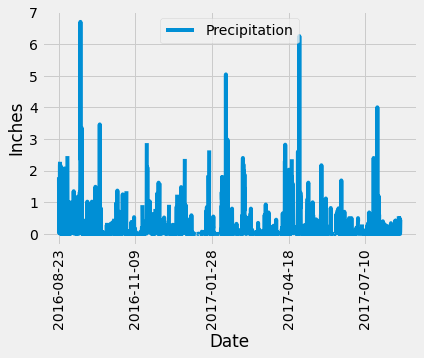

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
year_data_df.plot(x = "Date", y= "Precipitation", rot = 90)
plt.xlabel("Date")
plt.ylabel("Inches")

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_data_df.describe()

,Precipitation,Temperature
count,2021.000000,2230.000000
mean,0.177279,74.590583
std,0.461190,4.611667
min,0.000000,58.000000
25%,0.000000,72.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(station.station)).all() 

[(9)]

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
placeholder = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station)\
    .desc()).all()
most_active = str(placeholder[0][0])
most_active

'USC00519281'

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.max(measurement.tobs))\
    .filter(measurement.station == most_active).all()

[(54.0, 85.0, 85.0)]

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_data = session.query(measurement.station, measurement.date, measurement.prcp, measurement.tobs)\
    .filter(measurement.station == most_active)\
    .filter(measurement.date >= year_back_date).all()
active_data_df = pd.DataFrame(active_data, columns=["Station", "Date", "Precipitation", "Temperature"])

In [19]:
active_data_df

,Station,Date,Precipitation,Temperature
0,USC00519281,2016-08-23,1.79,77.0
1,USC00519281,2016-08-24,2.15,77.0
2,USC00519281,2016-08-25,0.06,80.0
3,USC00519281,2016-08-26,0.01,80.0
4,USC00519281,2016-08-27,0.12,75.0
...,...,...,...,...
347,USC00519281,2017-08-14,0.00,77.0
348,USC00519281,2017-08-15,0.32,77.0
349,USC00519281,2017-08-16,0.12,76.0
350,USC00519281,2017-08-17,0.01,76.0


Text(0.5, 0, 'Temperature')

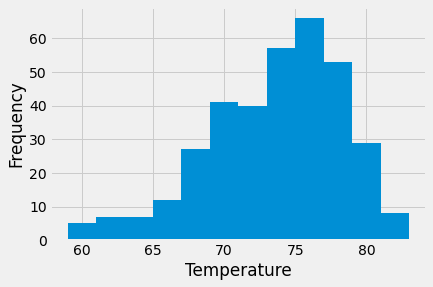

In [20]:
active_data_df["Temperature"].plot.hist(bins=12)
plt.xlabel("Temperature")

# Close session

In [21]:
# Close Session
session.close()